In [1]:
import warnings
import pandas as pd
import miceforest as mf
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [2]:
filepath='./../data/train.csv'
df=pd.read_csv(filepath)

<p style="font-size:25px;">In this notebook, I will be cleaning the data for this project. </p>
</br>
<p style="font-size:16px;">Because all of the data exists in one table, there isn't much to do in terms of cleaning. My proccess consists of three parts.</p>
<ol>
    <li><b>Dropping ordinal data.</b></li>
    <dd>Oridinal data are categorical variables that have an order. It is unclear what determines their order, but it does exist. Take the rating system for products on Amazon as an example. You know a 4 star rating is better than a 5 star rating, but its unclear what differentiates the two ratings. Because there is a no clear definition of the different ratings, the ordinal data is too subjective to be usefull in this project. </dd>
    <li><b>Dropping "Miscellaneous" columns</b></li>
    <dd>According to the data dictionary, the "MiscFeature" column records miscellaneous features not covered in other categories and the "MiscVal" column records the value of the miscellaneous feature. These features include things like elevators and tennis courts which aren't very common so I decided to drop these columns. </dd>
    <li><b>Handling missing values</b></li>
    <dd>Missing data is a real challenge for machine learning algorithms. They rely on the data to learn so not having it is  never a good thing. When handling missing values, I try to keep as much data as I can with imputation while dropping any data that is beyond saving. For imputation, I started by using the Mice algorithm to replace the missing values. When that didn't work, I simply imputed the median for numeric data and mode for categorical data. </dd>
</ol>  

In [3]:
print(f'Before cleaning, the data has {df.shape[0]} rows and {df.shape[1]} columns.')

Before cleaning, the data has 1460 rows and 81 columns.


<p style=style="font-size:15px;font-weight: bold;">Dropping the ordinal data</p>

In [4]:
df=df[[i for i in df.columns if 'qual' not in i.lower()]]
df=df[[i for i in df.columns if 'qc' not in i.lower()]]
df=df[[i for i in df.columns if 'qu' not in i.lower()]]
df=df[[i for i in df.columns if 'fintype' not in i.lower()]]
df=df[[i for i in df.columns if 'cond' not in i.lower()[-4:]]]

<p style=style="font-size:15px;font-weight: bold;">Dropping "Miscellaneous" columns</p>

In [5]:
df=df.drop(columns=[ "MiscFeature", "MiscVal"])

<p style=style="font-size:15px;font-weight: bold;">Handling missing values</p>

In [6]:
df.isna().sum().sum() #counting the number of missing values

3105

<p style="font-size:16px;">There are almost 3000 missing values in the data set. I'll start handling the missing values by looking to see where they are.</p>

In [7]:
temp=df.isna().sum()
pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])

,Number of Missing Values
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtExposure,38
Electrical,1
GarageType,81
GarageYrBlt,81
GarageFinish,81
Fence,1179


<p style="font-size:16px;">There are columns with a lot of missing data. I'll drop the columns that are missing more than 50% of the total number of entrities. 50% is an arbitrary choice, but it seems like a good starting point.</p>

In [8]:
df=df.drop(columns=temp[temp[temp.index]>0.5*1460].index)

In [9]:
temp=df.isna().sum()
pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])

,Number of Missing Values
LotFrontage,259
MasVnrType,8
MasVnrArea,8
BsmtExposure,38
Electrical,1
GarageType,81
GarageYrBlt,81
GarageFinish,81


<p style="font-size:16px;">For the rest of the data, I will impute the missing values using the Mice algorithm, then the median/mode depending on the variable type.</p>

In [10]:
 kernel = mf.ImputationKernel(
  data=df[df.corr().columns],
  save_all_iterations=True,
  random_state=1991
)
kernel.mice(10)

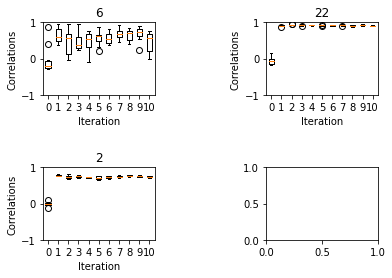

In [11]:
kernel.plot_correlations(wspace=1,hspace=1)

<p style="font-size:16px;">The mice algorithm has high confidence in the imputations for variable 2 and 22 which correspond to 'LotFrontage' and 'GarageYrBlt', so I will impute values made by the algorithm in those columns</p>

In [12]:
temp=[df.corr().columns[22],df.corr().columns[2]]

In [13]:
new_data_imputed = kernel.impute_new_data(df[df.corr().columns])
for i in temp:
    df[i]=new_data_imputed.complete_data(0)[i]

In [14]:
temp=df.isna().sum()
pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])

,Number of Missing Values
MasVnrType,8
MasVnrArea,8
BsmtExposure,38
Electrical,1
GarageType,81
GarageFinish,81


<p style="font-size:16px;">For the remaining numeric columns, I impute the median because the mice algorithm couldn't converge on those values for imputation. I repeat my imputation process (<i>imputing the mice algorithm generated values for columns it could confidently impute then imputing the mode for the columns the algorithm couldn't confidently impute</i>) for the categorical variables aswell.</p>

In [15]:
quant=[i for i in temp[temp[temp.index]!=0].index if i in df.corr().columns]
for col in quant:
    df[col]=[i if i==i else df[col].median() for i in df[col]]

In [16]:
temp=df.isna().sum()
pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])

,Number of Missing Values
MasVnrType,8
BsmtExposure,38
Electrical,1
GarageType,81
GarageFinish,81


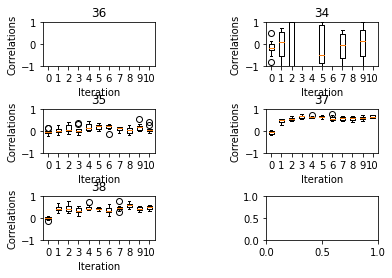

In [17]:
temp=df.isna().sum()
temp=pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])

labelencoder = LabelEncoder()
qual=df[temp.index]
for i in qual.columns:
    qual[i+'_Imp']=labelencoder.fit_transform(qual[i])
    
for i in temp.index:
    n=qual[qual[i]!=qual[i]][i+'_Imp'].value_counts().index[0]
    qual[i+'_Imp']=[i if i !=n else None for i in qual[i+'_Imp']]
    
temp=df[df.corr().columns].join(qual.drop(columns=temp.index))

kernel = mf.ImputationKernel(
  data=temp,
  save_all_iterations=True,
  random_state=1991
)
kernel.mice(10)

kernel.plot_correlations(wspace=1,hspace=1)

In [18]:
cols=[temp.columns[37],temp.columns[38]]
new_data_imputed = kernel.impute_new_data(temp)
temp=qual.columns[int(len(qual.columns)/2):]
for col in cols:
    qual[col]=new_data_imputed.complete_data(0)[col]
    
qual=qual[[i[:-4] for i in cols]+cols]
cols=[i[:-4] for i in cols]

for i in cols:
    temp=qual[[j for j in qual.columns if i in j]]
    temp=temp.drop_duplicates().dropna()
    d={}
    for j in temp.values:
        d[j[1]]=j[0]
    col=pd.DataFrame(qual[i+'_Imp'])
    qual[i+'_Imp']=col.applymap(lambda x: d[x])
    
qual=qual.drop(columns=cols)
qual.columns=cols
for i in cols:
    df[i]=qual[i]

In [19]:
temp=df.isna().sum()
pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])

,Number of Missing Values
MasVnrType,8
BsmtExposure,38
Electrical,1


<p style="font-size:16px;">The columns above are the columns the mice algorithm couldn't confidently impute so i will impute each column with its respective mode.</p>

In [20]:
qual=pd.DataFrame(temp[temp[temp.index]!=0],columns=['Number of Missing Values'])
qual=qual.index
for col in qual:
    df[col]=[i if i==i else df[col].describe()['top'] for i in df[col]]

In [21]:
df.isna().sum().sum() #counting the number of missing values

0

<p style="font-size:16px;">I've removed all of the missing values.</p>

In [22]:
temp=df.shape
print(f'After cleaning, the data has {temp[0]} rows and {temp[1]} columns.')

After cleaning, the data has 1460 rows and 62 columns.


In [23]:
df.to_csv('./../data/train_clean.csv',index=False)